In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack, csr_matrix
import warnings
from sklearn.metrics import classification_report, roc_curve, auc

warnings.filterwarnings('ignore')


import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /Users/zuanming/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zuanming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
%cd Library/CloudStorage/GoogleDrive-zuanming@gmail.com/My Drive/Insitute_of_Data/Project3

[Errno 2] No such file or directory: 'Library/CloudStorage/GoogleDrive-zuanming@gmail.com/My Drive/Insitute_of_Data/Project3'
/Users/zuanming/Library/CloudStorage/GoogleDrive-zuanming@gmail.com/My Drive/Insitute_of_Data/Project3


# Data Loading

In [4]:
# Load the dataset
df_full = pd.read_csv('Suicide_Detection.csv', encoding='ISO-8859-1')
df = df_full.sample(n=5000, random_state=42)
df = df.drop(df.columns[0], axis=1)  # Drops the first column (index 0)
df.head()

,text,class
74414,I Don't know?7? Months self harm free and the ...,suicide
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
14043,I've honestly got no idea what to do anymore.I...,suicide
30673,Do you ever just cry? Like you just think abou...,non-suicide


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 74414 to 25048
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   class   5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [6]:
# Convert to string type
df['text'] = df['text'].astype('string')
df['class'] = df['class'].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 74414 to 25048
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   string
 1   class   5000 non-null   string
dtypes: string(2)
memory usage: 117.2 KB


In [7]:
df.shape

(5000, 2)

In [8]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [9]:
df.isna().sum()

text     0
class    0
dtype: int64

In [10]:
df.describe()

,text,class
count,5000,5000
unique,5000,2
top,I Don't know?7? Months self harm free and the ...,non-suicide
freq,1,2537


# Data Processing

In [26]:
# Load SpaCy's small English Language model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-letters and whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Handle negations
    text = re.sub(r'\bnot\b \b(\w+)\b', r'NOT_\1', text)

    # Tokenize
    tokens = word_tokenize(text)

   
    # Remove stopwords and lemmatize, ensuring tokens are valid
    stop_words = set(stopwords.words('english'))
    tokens = [token.lemma_ for token in nlp(' '.join(tokens)) if token.lemma_ and token.lemma_ not in stop_words]

    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 74414 to 25048
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5000 non-null   string
 1   class         5000 non-null   string
 2   cleaned_text  5000 non-null   object
dtypes: object(1), string(2)
memory usage: 156.2+ KB


# EDA

In [37]:
from wordcloud import WordCloud

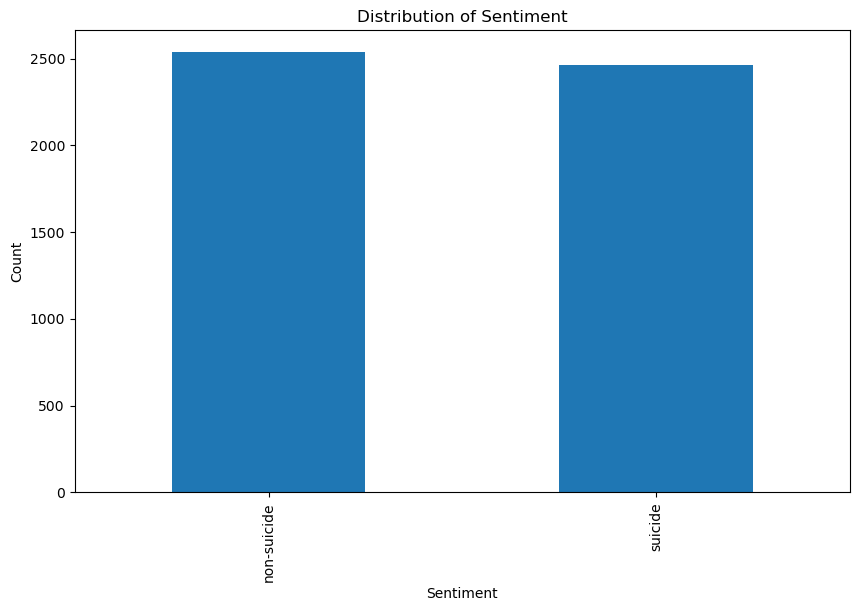

In [43]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
df['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word Cloud for positive and negative sentiment
from wordcloud import WordCloud

# Function to plot word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Extract texts for each sentiment category
positive_text = ' '.join(df[df['class'] == 'non-suicide']['cleaned_text'])
negative_text = ' '.join(df[df['class'] == 'suicide']['cleaned_text'])


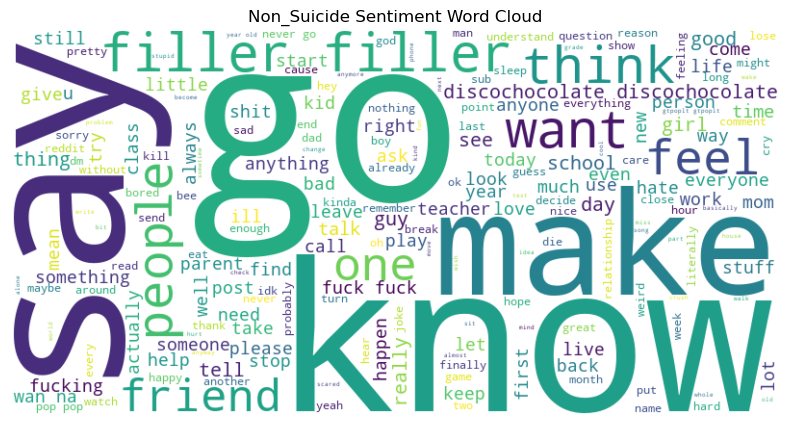

In [45]:
plot_wordcloud(positive_text, 'Non_Suicide Sentiment Word Cloud')

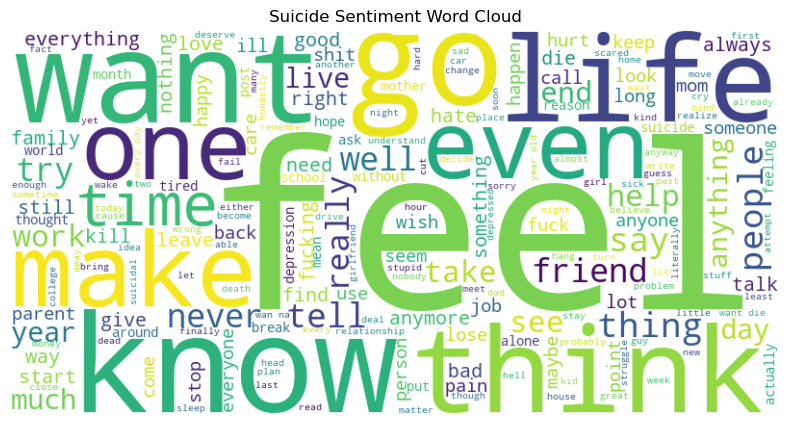

In [47]:
plot_wordcloud(negative_text, 'Suicide Sentiment Word Cloud')

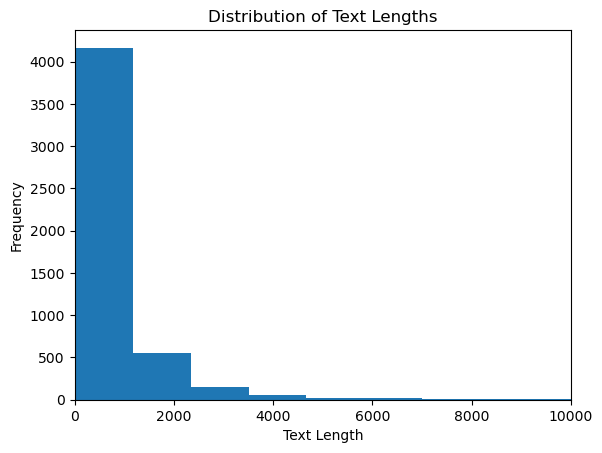

In [48]:
# Distribution of text lengths
# plt.figure(figsize=(10, 6))
df['text'].apply(len).plot(kind='hist', bins = 100)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 10000) 
plt.show()

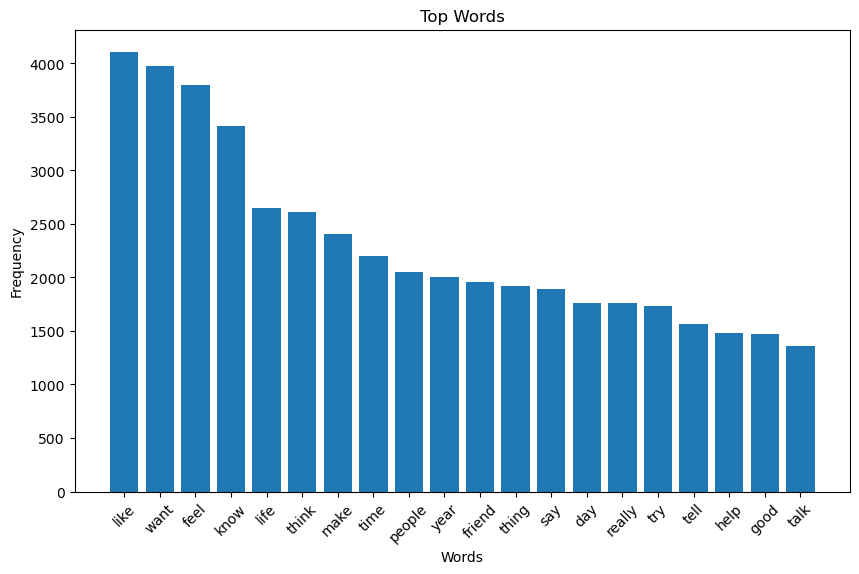

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot top n words
def plot_top_words(text_data, title, n=20):
    vectorizer = CountVectorizer(stop_words='english', max_features=n)
    bag_of_words = vectorizer.fit_transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, freqs = zip(*words_freq)
    plt.figure(figsize=(10, 6))
    plt.bar(words, freqs)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
    
# Plot top words
plot_top_words(df['cleaned_text'], 'Top Words')


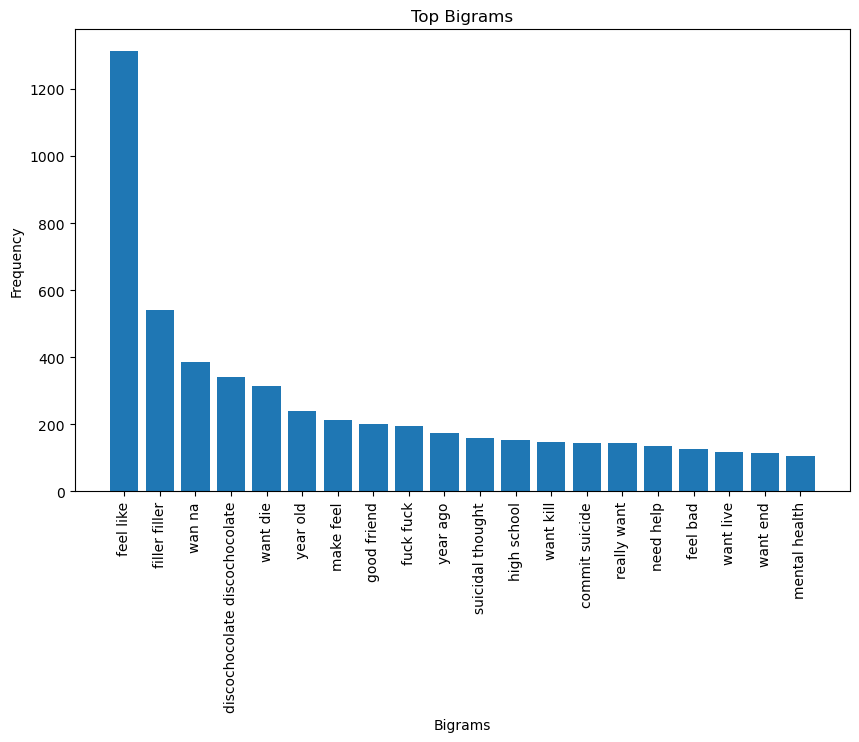

In [53]:


# Function to plot top n bigrams
def plot_top_bigrams(text_data, title, n=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=n)
    bag_of_bigrams = vectorizer.fit_transform(text_data)
    sum_bigrams = bag_of_bigrams.sum(axis=0)
    bigrams_freq = [(bigram, sum_bigrams[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]
    bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)
    bigrams, freqs = zip(*bigrams_freq)
    plt.figure(figsize=(10, 6))
    plt.bar(bigrams, freqs)
    plt.title(title)
    plt.xlabel('Bigrams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Plot top bigrams
plot_top_bigrams(df['cleaned_text'], 'Top Bigrams')

# Split Data

In [56]:
# Prepare data for classification
X = df[['cleaned_text']]
y = df['class'].map({'non-suicide': 0, 'suicide': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorisation

In [59]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_features=5000, ngram_range=(2, 3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_text'])

# EDA for TF-IDF
print("TF-IDF Features:")
print(f"Number of features: {X_train_tfidf.shape[1]}")
print(f"Sparsity: {X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.2%}")


TF-IDF Features:
Number of features: 5000
Sparsity: 0.28%


# Topic Modelling

In [61]:
# LDA
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20, random_state=42)
X_train_lda = lda_model.fit_transform(X_train_tfidf)
X_test_lda = lda_model.transform(X_test_tfidf)

# Word Embedding

In [64]:
from gensim.models import Word2Vec

In [65]:
# Word2Vec
def train_word2vec(sentences):
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
    return model

def get_sentence_vector(model, sentence):
    words = word_tokenize(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)
    return np.mean(word_vectors, axis=0)

word2vec_model = train_word2vec(X_train['cleaned_text'])
X_train_w2v = np.array([get_sentence_vector(word2vec_model, sentence) for sentence in X_train['cleaned_text']])
X_test_w2v = np.array([get_sentence_vector(word2vec_model, sentence) for sentence in X_test['cleaned_text']])


In [66]:
# Combine LDA and Word2Vec features for dimensionality reduction
X_train_combined = np.hstack([X_train_lda, X_train_w2v])
X_test_combined = np.hstack([X_test_lda, X_test_w2v])

In [139]:
# EDA for Word2Vec
print("\nWord2Vec Features:")
print(f"Vector size: {X_train_w2v.shape[1]}")
print("Sample vector:", X_train_w2v[0])


Word2Vec Features:
Vector size: 100
Sample vector: [-1.99003771e-01  2.83731490e-01  1.29046306e-01  2.77341157e-02
  1.85679868e-02 -8.53262246e-01  3.60811740e-01  8.66730928e-01
 -2.37078547e-01 -1.54642403e-01 -8.85243416e-02 -5.20249844e-01
 -1.48092285e-01  2.70579070e-01 -7.54239112e-02 -1.68296397e-01
  2.64087230e-01 -2.94363916e-01 -1.35319933e-01 -6.92903817e-01
  1.10982195e-01  2.33989626e-01  1.43599823e-01 -1.34449482e-01
  1.54478967e-01 -1.05763070e-01 -2.78620362e-01  2.39178985e-02
 -3.20349634e-01 -2.23277777e-01  1.96670651e-01  6.63917810e-02
  2.07373753e-01 -2.65602499e-01 -1.05910510e-01  1.61599800e-01
  1.74010947e-01 -4.28864926e-01 -1.06653376e-02 -4.69600141e-01
 -1.70835733e-01 -2.93126404e-01  1.35565579e-01 -1.98193323e-02
  3.47293735e-01 -3.37299824e-01 -3.24204624e-01  4.20470312e-02
  3.60663235e-02  3.92993301e-01  1.00571476e-01 -5.85386008e-02
  3.52176093e-02 -3.17625962e-02 -6.42847568e-02  5.79060130e-02
  3.39409143e-01 -1.00200132e-01 -1.20

# PCA

In [69]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_combined)
X_test_pca = pca.transform(X_test_combined)


PCA:
Explained variance ratio: [0.51780465 0.25293319]


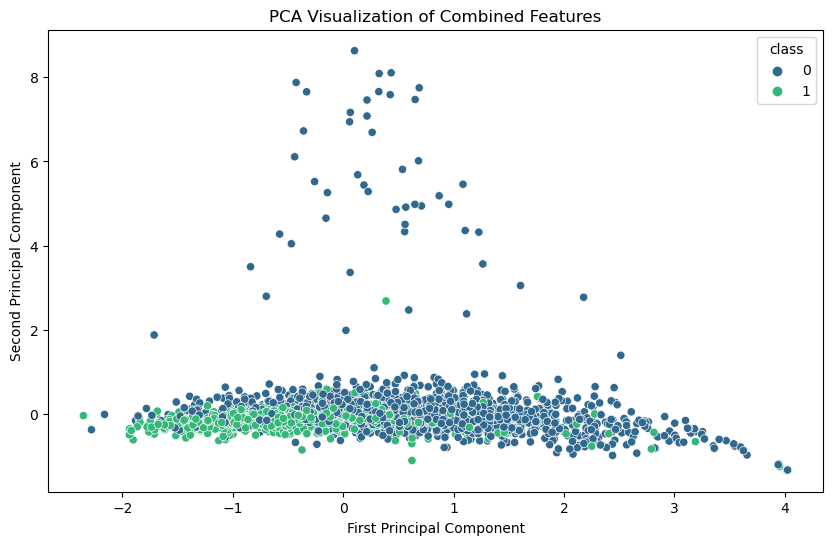

In [77]:
# EDA for PCA
print("\nPCA:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis')
plt.title("PCA Visualization of Combined Features")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

# TSNE

In [88]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_combined)

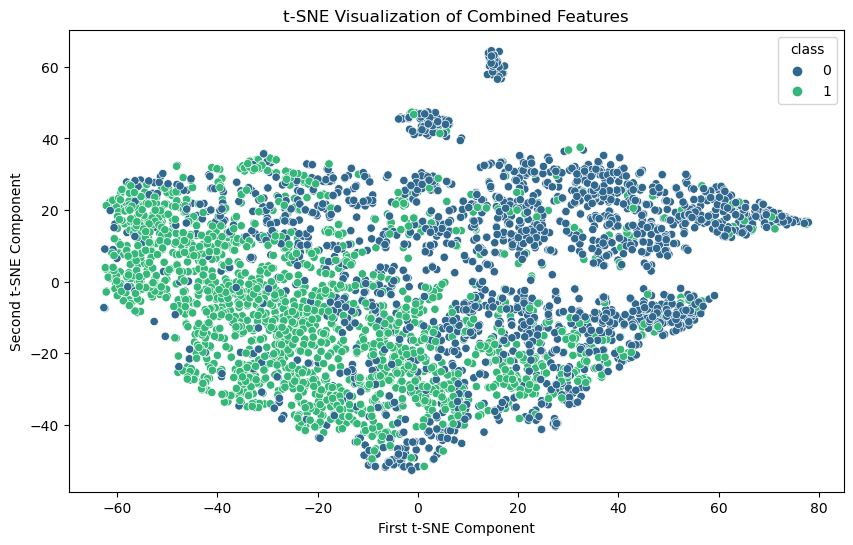

In [89]:
# EDA for t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette='viridis')
plt.title("t-SNE Visualization of Combined Features")
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.show()

# KMeans Clustering

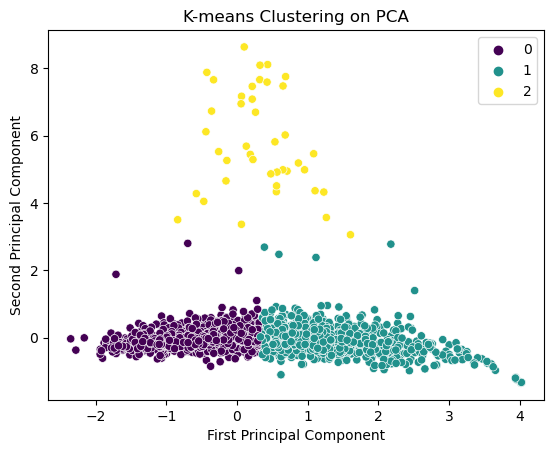

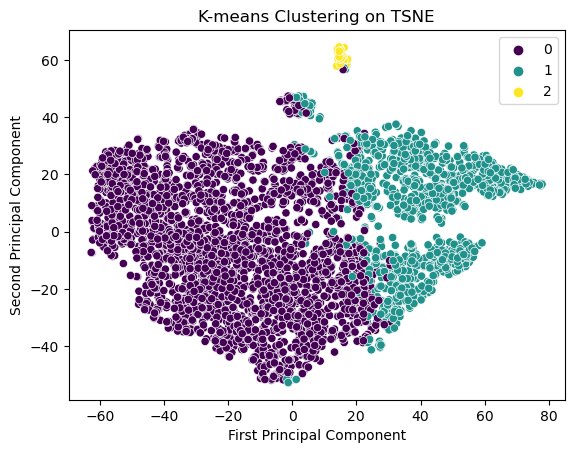

In [98]:
# K-means Clustering on PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42, init='k-means++')
train_clusters_pca = kmeans_pca.fit_predict(X_train_pca)
test_clusters_pca = kmeans_pca.predict(X_test_pca)

# K-means Clustering on t-SNE
kmeans_tsne = KMeans(n_clusters=3, random_state=42, init='k-means++')
train_clusters_tsne = kmeans_tsne.fit_predict(X_train_tsne)

# EDA for K-means

sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=train_clusters_pca, palette='viridis')
plt.title("K-means Clustering on PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=train_clusters_pca, palette='viridis')
plt.title("K-means Clustering on TSNE")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()


# Combine Features

In [114]:
# Combine all features
X_train_final = hstack([
    X_train_tfidf,
    csr_matrix(X_train_lda),
    csr_matrix(X_train_w2v),
    csr_matrix(X_train_pca),
    csr_matrix(train_clusters_pca.reshape(-1, 1))
])

X_test_final = hstack([
    X_test_tfidf,
    csr_matrix(X_test_lda),
    csr_matrix(X_test_w2v),
    csr_matrix(X_test_pca),
    csr_matrix(test_clusters_pca.reshape(-1, 1))
])


# Supervised Learning Model Training

In [173]:
# Train and evaluate models
# Define models with parameter grids for GridSearchCV
models = {
    'Logistic Regression': (LogisticRegression(random_state=42),
                            {'C': [0.1, 1, 10],
                             'solver': ['liblinear']}),
    'SVM': (SVC(random_state=42, probability=True),
            {'C': [0.1, 1, 10],
             'kernel': ['rbf', 'linear']}),
    'Random Forest': (RandomForestClassifier(random_state=42),
                      {'n_estimators': [100, 200],
                       'max_depth': [None, 10, 20, 30],
                       'max_features': ['sqrt', 'log2']}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42),
                          {'n_estimators': [100, 200],
                           'learning_rate': [0.01, 0.1, 0.2],
                           'max_depth': [3, 5, 7]})
}

# Train and evaluate models using GridSearchCV
results = {}
best_model = {}

for name, (model, param_grid) in models.items():
    print(f"\nPerforming GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_final, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    y_pred = best_model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy
    }
    
    print(f"\n{name} Best Parameters: {grid_search.best_params_}")
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    
# Find the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['best_model']
print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]['accuracy']}")



Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Logistic Regression Best Parameters: {'C': 10, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       505
           1       0.86      0.88      0.87       495

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Performing GridSearchCV for SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

SVM Best Parameters: {'C': 10, 'kernel': 'rbf'}
SVM Accuracy: 0.877
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       505
           1       0.88      0.87      0.88       495

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg      

# Evaluation

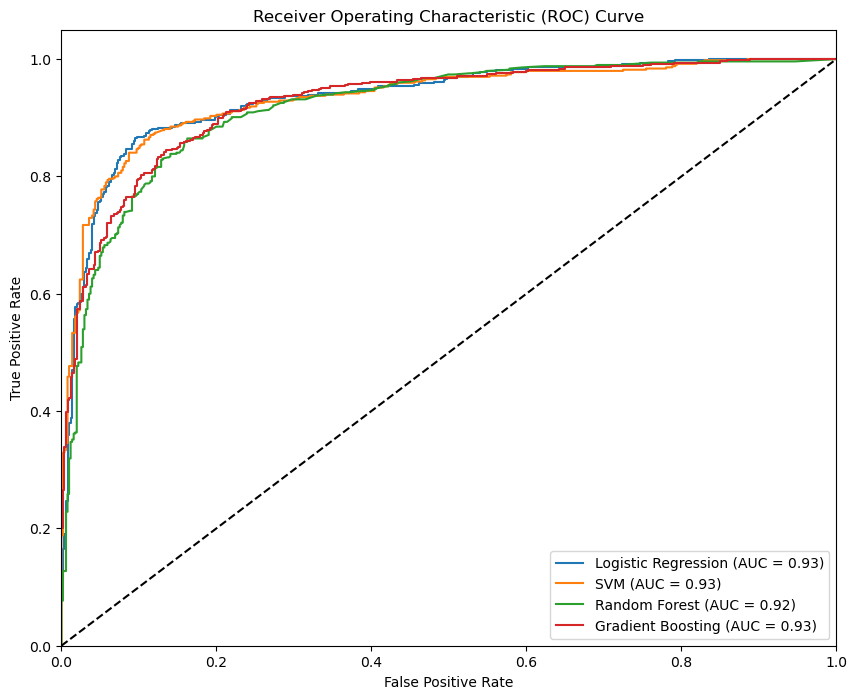

Logistic Regression AUC: 0.9342
SVM AUC: 0.9335
Random Forest AUC: 0.9184
Gradient Boosting AUC: 0.9267


In [175]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for name, model_info in results.items():
    model = model_info['best_model']
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
for name, model_info in results.items():
    model = model_info['best_model']
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"{name} AUC: {roc_auc:.4f}")

# Prediction & Evaluation

In [180]:
def predict_sentiment(texts):
    cleaned_texts = [preprocess_text(text) for text in texts]
    X_new_tfidf = tfidf_vectorizer.transform(cleaned_texts)
    X_new_lda = lda_model.transform(X_new_tfidf)
    X_new_w2v = np.array([get_sentence_vector(word2vec_model, sentence) for sentence in cleaned_texts])
    X_new_combined = np.hstack([X_new_lda, X_new_w2v])
    X_new_pca = pca.transform(X_new_combined)
    new_clusters = kmeans_pca.predict(X_new_pca)
    X_new_final = hstack([
        X_new_tfidf,
        csr_matrix(X_new_lda),
        csr_matrix(X_new_w2v),
        csr_matrix(X_new_pca),
        csr_matrix(new_clusters.reshape(-1, 1))
    ])
    
    # Predict probabilities
    probabilities = best_model.predict_proba(X_new_final)[:, 1]
    
    # Predict class (0 for non-suicide, 1 for suicide)
    predictions = best_model.predict(X_new_final)
    
    return predictions, probabilities

new_texts = [
    "I can't take this anymore",
    "Lawrence Wong is our new prime minister!",
    "AI will destroy us all",
    "Too tired of all this."
]

predictions, probabilities = predict_sentiment(new_texts)

for text, prediction, probability in zip(new_texts, predictions, probabilities):
    sentiment = "Suicidal" if prediction == 1 else "Non-suicidal"
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Probability of suicidal sentiment: {probability:.2f}")
    print()

Text: I can't take this anymore
Predicted sentiment: Suicidal
Probability of suicidal sentiment: 0.74

Text: Lawrence Wong is our new prime minister!
Predicted sentiment: Non-suicidal
Probability of suicidal sentiment: 0.04

Text: AI will destroy us all
Predicted sentiment: Non-suicidal
Probability of suicidal sentiment: 0.08

Text: Too tired of all this.
Predicted sentiment: Suicidal
Probability of suicidal sentiment: 0.61

